In [5]:
# Установка LightGBM и Optuna - библиотеки для подбора гиперпараметров
!pip install lightgbm optuna
from lightgbm import LGBMRegressor
import optuna
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import numpy as np
warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Financial\ Modeling/CMF/Хакатон\ от\ Сбера
!pwd

/content/drive/MyDrive/Financial Modeling/CMF/Хакатон от Сбера
/content/drive/MyDrive/Financial Modeling/CMF/Хакатон от Сбера


In [85]:
orders = pd.read_csv('orders.csv')
orders['date'] = pd.to_datetime(orders['date'])
partners_delays = pd.read_csv('partners_delays.csv')
partners_delays['dttm'] = pd.to_datetime(partners_delays['dttm'])
clusters = pd.read_excel('standard_scaler_clustering.xlsx')
partners_delays

,delivery_area_id,dttm,partners_cnt,delay_rate
0,0,2021-04-01 09:00:00,3.0,0.000000
1,0,2021-04-01 10:00:00,4.0,0.111111
2,0,2021-04-01 11:00:00,4.0,0.000000
3,0,2021-04-01 12:00:00,4.0,0.000000
4,0,2021-04-01 13:00:00,1.0,0.000000
...,...,...,...,...
1247466,592,2021-11-30 17:00:00,2.0,0.000000
1247467,592,2021-11-30 18:00:00,2.0,0.000000
1247468,592,2021-11-30 19:00:00,2.0,0.000000
1247469,592,2021-11-30 20:00:00,2.0,0.000000


In [95]:
orders

,delivery_area_id,date,orders_cnt
0,0,2021-04-01,24
1,0,2021-04-02,21
2,0,2021-04-03,33
3,0,2021-04-04,18
4,0,2021-04-05,32
...,...,...,...
97201,592,2021-11-26,56
97202,592,2021-11-27,50
97203,592,2021-11-28,46
97204,592,2021-11-29,73


In [87]:
clusters.columns = ['delivery_area_id', 'cluster']
clusters

,delivery_area_id,cluster
0,0,2
1,1,2
2,2,0
3,3,2
4,4,2
...,...,...
588,588,3
589,589,0
590,590,0
591,591,0


(array([1.118023e+06, 5.323400e+04, 4.510200e+04, 1.248900e+04,
        2.633000e+03, 1.008500e+04, 2.810000e+02, 8.900000e+01,
        8.000000e+00, 5.527000e+03]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

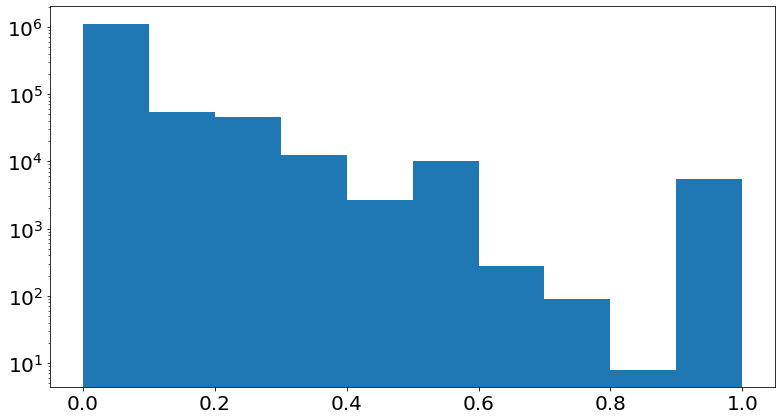

In [88]:
plt.yscale('log')
plt.hist(partners_delays['delay_rate'])

In [89]:
import features as f

orders = f.daily_order_counts(orders)

In [90]:
partners_delays['hour'] = partners_delays['dttm'].dt.hour
partners_delays['date'] = partners_delays['dttm'].dt.date
partners_delays

,delivery_area_id,dttm,partners_cnt,delay_rate,hour,date
0,0,2021-04-01 09:00:00,3.0,0.000000,9,2021-04-01
1,0,2021-04-01 10:00:00,4.0,0.111111,10,2021-04-01
2,0,2021-04-01 11:00:00,4.0,0.000000,11,2021-04-01
3,0,2021-04-01 12:00:00,4.0,0.000000,12,2021-04-01
4,0,2021-04-01 13:00:00,1.0,0.000000,13,2021-04-01
...,...,...,...,...,...,...
1247466,592,2021-11-30 17:00:00,2.0,0.000000,17,2021-11-30
1247467,592,2021-11-30 18:00:00,2.0,0.000000,18,2021-11-30
1247468,592,2021-11-30 19:00:00,2.0,0.000000,19,2021-11-30
1247469,592,2021-11-30 20:00:00,2.0,0.000000,20,2021-11-30


In [91]:
# partners_delays['daily_order_counts'
data = pd.merge(partners_delays, orders[['delivery_area_id', 'date', 'orders_cnt']],
         on=['delivery_area_id', 'date'], how='left')
# partners_delays['daily_order_counts'
data = pd.merge(data, clusters, on=['delivery_area_id'], how='left')

In [92]:
data

,delivery_area_id,dttm,partners_cnt,delay_rate,hour,date,orders_cnt,cluster
0,0,2021-04-01 09:00:00,3.0,0.000000,9,2021-04-01,24.0,2
1,0,2021-04-01 10:00:00,4.0,0.111111,10,2021-04-01,24.0,2
2,0,2021-04-01 11:00:00,4.0,0.000000,11,2021-04-01,24.0,2
3,0,2021-04-01 12:00:00,4.0,0.000000,12,2021-04-01,24.0,2
4,0,2021-04-01 13:00:00,1.0,0.000000,13,2021-04-01,24.0,2
...,...,...,...,...,...,...,...,...
1247466,592,2021-11-30 17:00:00,2.0,0.000000,17,2021-11-30,53.0,3
1247467,592,2021-11-30 18:00:00,2.0,0.000000,18,2021-11-30,53.0,3
1247468,592,2021-11-30 19:00:00,2.0,0.000000,19,2021-11-30,53.0,3
1247469,592,2021-11-30 20:00:00,2.0,0.000000,20,2021-11-30,53.0,3


In [93]:
data = f.date_features(data)
data

,delivery_area_id,dttm,partners_cnt,delay_rate,hour,date,orders_cnt,cluster,Month,Week,Day,Dayofweek,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start
0,0,2021-04-01 09:00:00,3.0,0.000000,9,2021-04-01,24.0,2,4,13,1,3,0,1,0,1
1,0,2021-04-01 10:00:00,4.0,0.111111,10,2021-04-01,24.0,2,4,13,1,3,0,1,0,1
2,0,2021-04-01 11:00:00,4.0,0.000000,11,2021-04-01,24.0,2,4,13,1,3,0,1,0,1
3,0,2021-04-01 12:00:00,4.0,0.000000,12,2021-04-01,24.0,2,4,13,1,3,0,1,0,1
4,0,2021-04-01 13:00:00,1.0,0.000000,13,2021-04-01,24.0,2,4,13,1,3,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247466,592,2021-11-30 17:00:00,2.0,0.000000,17,2021-11-30,53.0,3,11,48,30,1,1,0,0,0
1247467,592,2021-11-30 18:00:00,2.0,0.000000,18,2021-11-30,53.0,3,11,48,30,1,1,0,0,0
1247468,592,2021-11-30 19:00:00,2.0,0.000000,19,2021-11-30,53.0,3,11,48,30,1,1,0,0,0
1247469,592,2021-11-30 20:00:00,2.0,0.000000,20,2021-11-30,53.0,3,11,48,30,1,1,0,0,0


In [79]:
X = data.drop(['dttm','date','Month','Week','delay_rate'], axis=1)
y = data['delay_rate']

# Тренировка модели

In [80]:
# Разбиение на тренировочный, валидационный и тестовый наборы
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [81]:
# Функция для определения гиперпараметров
def objectives(trial):
    params = {
            'num_leaves': trial.suggest_int('num_leaves', 300, 4000),
            'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
            'max_bin': trial.suggest_int('max_bin', 2, 100),
            'learning_rate': trial.suggest_uniform('learning_rate',0, .1),
    }

    model = LGBMRegressor(**params)
    model.fit(X_train,y_train)
    score = model.score(X_val,y_val) #r2_score
    return score

In [82]:
# Поиск наилучшего набора гиперпараметров
opt = optuna.create_study(direction='maximize',
                          sampler=optuna.samplers.RandomSampler(seed=0))
opt.optimize(objectives, n_trials=20)

# Набор гиперпараметров с лучшим результатом на валидации 
trial = opt.best_trial
params_best = dict(trial.params.items())
params_best['random_seed'] = 42
    
# Предсказание с оптимальными гиперпараметрами на тестовой выборке
model_o = LGBMRegressor(**params_best)
model_o.fit(X_train, y_train)
print('Коэффициент детерминации на тестовой выборке:')
model_o.score(X_test, y_test)

[I 2022-10-04 21:19:10,289] A new study created in memory with name: no-name-fe4f4047-0d36-4d17-8628-20bb2d89fbfe
[I 2022-10-04 21:20:32,609] Trial 0 finished with value: -0.015016122689017308 and parameters: {'num_leaves': 2331, 'n_estimators': 718, 'max_bin': 61, 'learning_rate': 0.05448831829968969}. Best is trial 0 with value: -0.015016122689017308.
[I 2022-10-04 21:21:32,533] Trial 1 finished with value: -0.026285322414959955 and parameters: {'num_leaves': 1867, 'n_estimators': 650, 'max_bin': 45, 'learning_rate': 0.08917730007820798}. Best is trial 0 with value: -0.015016122689017308.
[I 2022-10-04 21:22:43,688] Trial 2 finished with value: -0.009617988962060675 and parameters: {'num_leaves': 3866, 'n_estimators': 389, 'max_bin': 80, 'learning_rate': 0.05288949197529045}. Best is trial 2 with value: -0.009617988962060675.
[I 2022-10-04 21:24:55,921] Trial 3 finished with value: 0.030615901000343948 and parameters: {'num_leaves': 2402, 'n_estimators': 927, 'max_bin': 9, 'learning_

Коэффициент детерминации на тестовой выборке:


0.053194753390482075

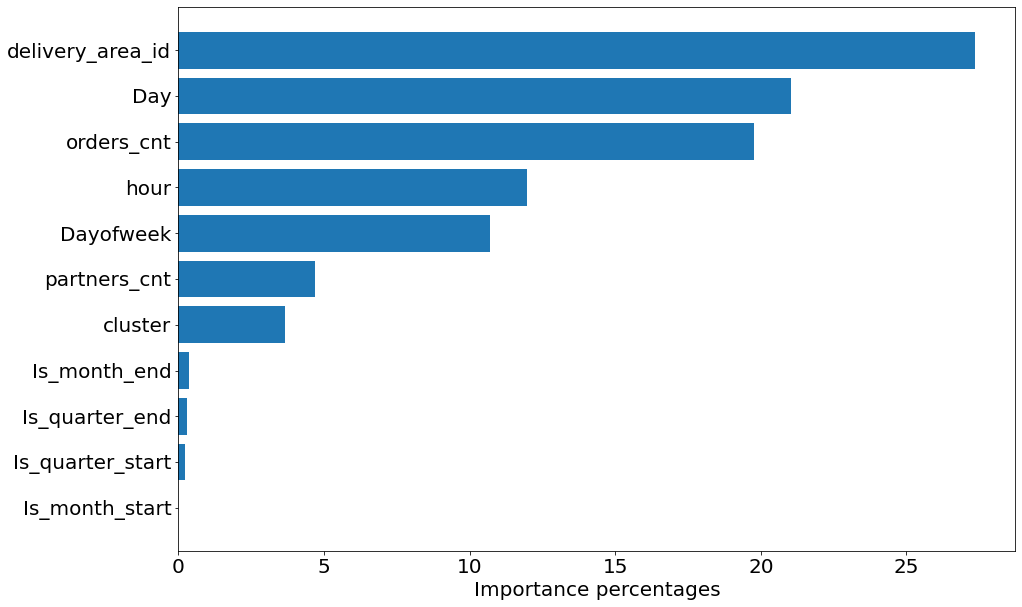

In [94]:
 # График с распределением feature importance
feature_importances = (model_o.feature_importances_ / sum(model_o.feature_importances_)) * 100

results = pd.DataFrame({'Features': X_train.columns,
                        'Importances': feature_importances})
results.sort_values(by='Importances', inplace=True)
large = 20; med = 16; small = 12;
params = {'axes.titlesize': large,
          'figure.figsize': (13, 7),
          'axes.labelsize': large,
          'axes.titlesize': large,
          'xtick.labelsize': large,
          'ytick.labelsize': large,
          'figure.titlesize': large}
plt.rcParams.update(params)

plt.figure(figsize=(15,10))
ax = plt.barh(results['Features'], results['Importances'])
plt.xlabel('Importance percentages')
plt.show()